# ICESAT-2 pond depth estimate using Robust Density-Based Moving Average

This is a very preliminary algorithm...

In [1]:
%matplotlib notebook
import copy
import hdbscan
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import pickle as pkl
import seaborn as sns
from sklearn.neighbors import KDTree
from scipy.signal import find_peaks
from scipy.interpolate import UnivariateSpline
from os import listdir, makedirs
from os.path import isfile, join, exists
from scipy.io import loadmat
from IPython.display import display, Markdown
from sklearn.neighbors import KernelDensity

## Load the Amery pond data

In [2]:
fn_IS2 = 'data/amery_ponds_icesat2_data.pkl'
with open(fn_IS2, 'rb') as handle:
    is2data = pkl.load(handle)
ponds = list(is2data)

## define function for robust rolling mean

In [3]:
def robustRollingMean(df,n_iter=5,res_start=10.0,res_end=1.0,width_start=40.0,width_end=10.0,vert_start=1.0,vert_end=0.2):
    res_f = (res_end / res_start)**(1/(n_iter-1))
    width_f = (width_end / width_start)**(1/(n_iter-1))
    vert_f = (vert_end / vert_start)**(1/(n_iter-2))
    
    # do a KD tree query for radius neighbors
    df['xnorm'] = np.linspace(np.min(df.x_atc), np.max(df.x_atc), len(df.x_atc)) / 100
    Xn = np.array(df[['xnorm','h']])
    kdt = KDTree(Xn, leaf_size=40)
    idx, dist = kdt.query_radius(Xn, r=0.5, count_only=False, return_distance=True)
    df['density'] = [np.sum(np.exp(-10*x**2)) for x in dist]
    df.density -= 1
    
    for it in range(n_iter):
        res = res_start * res_f**it
        wid = width_start * width_f**it
        vert_scale = vert_start * vert_f**it
        if it == 0:
            vscale_print = np.nan
        else:
            vscale_print = vert_start * vert_f**(it-1)
        print('iter: %2d, res: %5.2f, wid: %5.2f, vert_scale: %5.2f' % ((it+1),res,wid,vscale_print))
        evaldf = pd.DataFrame(np.arange(np.min(df.x_atc),np.max(df.x_atc)+res,step=res),columns=['x_atc'])
        h_arr = np.full_like(evaldf.x_atc,fill_value=np.nan)
        for i,x in enumerate(evaldf.x_atc):
            dfi = df[np.abs(df.x_atc-x)<wid].copy()
            dfi['weights'] = ((1-np.abs(((dfi.x_atc-x)/wid)**3))**3)
            if it <= 1:
                dfi['weights'] = dfi['weights'] * dfi.density
            if it > 0:
                dfi['weights'] = dfi['weights'] * dfi['vert_weight']
            #TODO: could actually make this a regression (with wider window) in iterations > 0 (i.e. robust LOWESS)
            h_arr[i] = np.average(dfi.h,weights=dfi.weights)
        evaldf['h'] = h_arr
        sc = 20
        xvals = np.arange(np.min(df.x_atc/sc),np.max(df.x_atc/sc),step=0.1)
        heights = np.interp(xvals, evaldf.x_atc/sc, evaldf.h, left=np.nan, right=np.nan)
        X1 = np.vstack((xvals,heights)).T
        X2 = np.array(df[['x_atc','h']])
        X2[:,0] = X2[:,0]/sc
        tree = KDTree(X1, leaf_size=2)
        distkd, ind = tree.query(X2, k=1)
        df['vert_weight'] = np.exp2(- (1/vert_scale) * distkd**2)
    df['vert_dist'] = df.h - np.interp(df.x_atc, evaldf.x_atc, evaldf.h, left=np.nan, right=np.nan)    
    evaldf['lat'] = np.interp(evaldf.x_atc, df.x_atc, df.lat, left=np.nan, right=np.nan)
    return (df,evaldf)

## loop through all ponds to find flat and curved surfaces

<IPython.core.display.Javascript object>


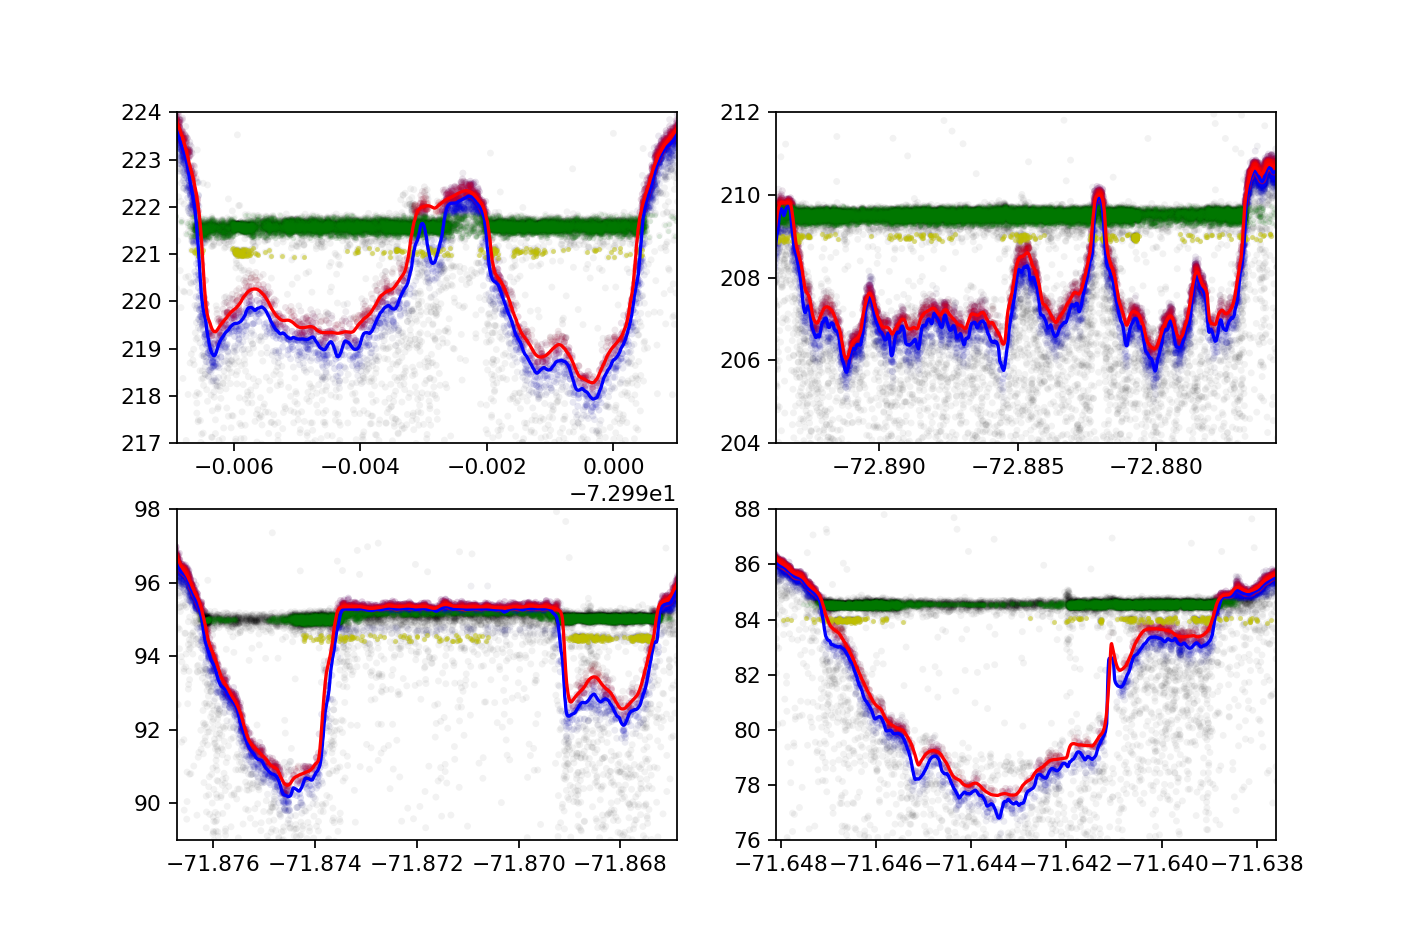

POND_ID: pond1
surface height: 221.57615539550682
iter:  1, res: 10.00, wid: 20.00, vert_scale:   nan
iter:  2, res:  5.62, wid: 16.82, vert_scale:  1.00
iter:  3, res:  3.16, wid: 14.14, vert_scale:  0.58
iter:  4, res:  1.78, wid: 11.89, vert_scale:  0.34
iter:  5, res:  1.00, wid: 10.00, vert_scale:  0.20
iter:  1, res: 10.00, wid: 20.00, vert_scale:   nan
iter:  2, res:  5.62, wid: 20.00, vert_scale:  1.00
iter:  3, res:  3.16, wid: 20.00, vert_scale:  0.46
iter:  4, res:  1.78, wid: 20.00, vert_scale:  0.22
iter:  5, res:  1.00, wid: 20.00, vert_scale:  0.10
POND_ID: pond2
surface height: 209.5093353271476
iter:  1, res: 10.00, wid: 20.00, vert_scale:   nan
iter:  2, res:  5.62, wid: 16.82, vert_scale:  1.00
iter:  3, res:  3.16, wid: 14.14, vert_scale:  0.58
iter:  4, res:  1.78, wid: 11.89, vert_scale:  0.34
iter:  5, res:  1.00, wid: 10.00, vert_scale:  0.20
iter:  1, res: 10.00, wid: 20.00, vert_scale:   nan
iter:  2, res:  5.62, wid: 20.00, vert_scale:  1.00
iter:  3, res:  3

In [4]:
result_dfs = []
surf_heights = []
fig = plt.figure(figsize=[9, 6])
for i,pond in enumerate(ponds):
    print('POND_ID:', pond)
    p = is2data[pond]
    df = pd.DataFrame(np.vstack((p['atl03_lat'],
                                 p['atl03_xatc'],
                                 p['atl03_h'])).T,
                      columns=['lat', 'x_atc', 'h'])
    df.x_atc -= min(df.x_atc)
    
    # get elevation of the flat water surface
    stp = 0.25
    bins = np.arange(df.h.min(),df.h.max(),step=stp)
    hist = np.histogram(df.h,bins=bins)
    d1 = hist[1][np.argmax(hist[0])] + stp/2
    pick = ((df.h > (d1-1)) & (df.h < (d1+1)))
    stp = 0.01
    bins = np.arange(d1-1,d1+1,step=stp)
    hist = np.histogram(df.h[pick],bins=bins)
    mpts = hist[1][:-1]+stp/2
    peaks, properties = find_peaks(hist[0], prominence=400, width=3, rel_height=0.5)
    surf_height = mpts[peaks][0]
    print('surface height:', surf_height)
    surf_heights.append(surf_height)

    # remove double reflections
    df["isdrheight"] = ((df.h > (surf_height-0.65)) & (df.h < (surf_height-0.45)))
    dfdr = df.query("isdrheight").copy()
    df = df.query("not isdrheight").copy()
    dfdr['xnormalized'] = dfdr.x_atc/300
    clustdat = np.array(dfdr[['xnormalized','h']])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=20,allow_single_cluster=True).fit(clustdat)
    dfdr['doubleref'] = clusterer.labels_ > -1
    df['doubleref'] = False
    dfdr.drop('xnormalized',axis=1,inplace=True)
    df = df.append(dfdr)

    # remove the flat water surface
    min_surf = mpts[peaks] - 3 * (mpts[peaks] - mpts[int(np.round(properties["left_ips"]))])
    max_surf = surf_height + 3 * (-mpts[peaks] + mpts[int(np.round(properties["right_ips"]))])
    df["issurfheight"] = ((df.h > min_surf[0]) & (df.h < max_surf[0]))
    dfsurf = df.query("issurfheight").copy()
    df = df.query("not issurfheight").copy()
    dfsurf['xnormalized'] = dfsurf.x_atc/2000
    clustdat = np.array(dfsurf[['xnormalized','h']])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=100,allow_single_cluster=True).fit(clustdat)
    dfsurf['surf'] = clusterer.labels_ > -1
    df['surf'] = False
    dfsurf.drop('xnormalized',axis=1,inplace=True)
    df = df.append(dfsurf)
    df.sort_values(by='x_atc',inplace=True)
    df2 = df.query("not issurfheight and not doubleref").copy()
    
    # find reflective surface in data where the flat water surface has been removed
    datadf, evaldf = robustRollingMean(df2,n_iter=5,width_start=20.0,)
    datadf["isbottom"] = ((datadf.vert_dist > 0) & (datadf.vert_dist < 1.0))
    dfbottom = datadf.query("isbottom").copy()
    dfbott, resultdf = robustRollingMean(dfbottom,n_iter=5,res_start=10.0,width_start=20.0,width_end=20.0,vert_start=1.0,vert_end=0.1)
    
    result_dfs.append(resultdf)
    ax = fig.add_subplot(2,2,i+1)
    h_atl03 = ax.scatter(df.lat,df.h,s=10,c='k',
                         alpha=0.05,edgecolors='none',label='ATL03')
    r, g, b = 0, 0, 1
    colsalpha = [(r, g, b, alpha) for alpha in 0.1*datadf.vert_weight]
    h_atl03 = ax.scatter(datadf.lat,datadf.h,s=10,c=colsalpha,edgecolors='none',label='ATL03')
    r, g, b = 1, 0, 0
    colsalpha = [(r, g, b, alpha) for alpha in 0.1*dfbott.vert_weight]
    h_atl03_res = ax.scatter(dfbott.lat,dfbott.h,s=10,c=colsalpha,edgecolors='none',label='ATL03')
    ax.scatter(df.lat[df.doubleref.eq(True)],df.h[df.doubleref.eq(True)], s=5, linewidth=0, alpha=0.5, c='y');
    ax.scatter(df.lat[df.surf.eq(True)],df.h[df.surf.eq(True)], s=5, linewidth=0, alpha=0.1, c='g');
    ax.plot(evaldf.lat,evaldf.h,c='b')
    ax.plot(resultdf.lat,resultdf.h,c='r')
    ax.set_ylim(p['ylims_plot'])
    ax.set_xlim(p['xlims_plot'])

## get depth from water surface elevation and robust curve fitted through the rest of the data

In [5]:
for i,df in enumerate(result_dfs):
    sh = surf_heights[i]
    df['depth'] = [sh-h if sh>h else 0 for h in df.h]
    result_dfs[i] = df.iloc[:-1,:]

## save data

In [6]:
filename_out = 'data/arndt/pondsRDBmovmean.pkl'
with open(filename_out, 'wb') as handle:
    pkl.dump(result_dfs, handle, protocol=pkl.HIGHEST_PROTOCOL)